In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW, Adam, SGD
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import Dataset, DataLoader

from torch.autograd import Variable
import time
from scipy import sparse
import joblib

In [2]:
import pandas as pd
from tqdm.auto import tqdm

from timeit import default_timer as timer
from torch.profiler import profile, record_function, ProfilerActivity

In [3]:
# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Utils Function

In [4]:
def print_train_time(start:float, end:float, device: torch.device = None):
    """print difference between start and end time"""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [5]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [6]:
def results(res: str):
    res_lst = res.split('\n')

    data = []
    for row in res_lst[3:-4]:
        row_split = [sp.strip() for sp in row[57:].split('  ') if sp != '']
        data.append(row_split)

    index = [l[:57].strip() for l in res_lst[3:-4]]

    head = [c.strip() for c in res_lst[1].strip().split('  ') if c != '']

    df = pd.DataFrame(data, columns=None)
    df.columns = head[1:]
    df.index = index

    return df

# Data

In [7]:
import joblib
from torch.utils import data

In [8]:
train_data = 'train.jb'
valid_data = 'test.jb'

In [9]:
n_workers = 0
valid_steps = 1
save_steps = 50
epochs = 25

lr = 0.001
batch_size = 128

In [10]:
train_x, train_y = joblib.load(train_data)
val_x, val_y = joblib.load(valid_data)

train_x = np.swapaxes(train_x, 1 , 2)
val_x = np.swapaxes(val_x, 1 , 2)


train_y, val_y = pd.get_dummies(train_y).values, pd.get_dummies(val_y).values

train_set = data.TensorDataset(torch.Tensor(train_x), torch.Tensor(train_y))
valid_set = data.TensorDataset(torch.Tensor(val_x), torch.Tensor(val_y))

In [11]:
train_dataloader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=n_workers,
    pin_memory=True
  )

val_dataloader = DataLoader(
    valid_set,
    batch_size=len(valid_set),
    num_workers=n_workers,
    drop_last=True,
    pin_memory=True
  )

# Experiament

In [12]:
from model import RCModel
from training_function import train_step, test_step, accuracy_fn

In [13]:
device = 'cpu'

In [14]:
torch.manual_seed(42)
model = RCModel(n=20).to(device)
next(model.parameters()).device

device(type='cpu')

### Freezing layers

In [15]:
params = model.state_dict()
params.keys()

odict_keys(['L1.internal_weights', 'L1._input_weights', 'lin_output.weight'])

In [16]:
for name, param in model.named_parameters():  
    if param.requires_grad and 'lin_output' not in name:  
        param.requires_grad = False

In [17]:
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch:0.9**epoch)
loss_fn = nn.CrossEntropyLoss()

In [18]:
start_time = timer()
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------------")

    train_step(model=model,
               data_loader=train_dataloader, 
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)

    test_step(model=model,
               data_loader=val_dataloader, 
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device)
    scheduler.step()
end_time = timer()
print(f'Time Consumtion: {end_time-start_time} sec')

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0
-------------
Train loss: 0.58033 | Train acc: 79.63%
Test loss: 0.43356 | Test acc: 89.53 %

Epoch: 1
-------------
Train loss: 0.46131 | Train acc: 81.84%
Test loss: 0.34459 | Test acc: 89.85 %

Epoch: 2
-------------
Train loss: 0.41291 | Train acc: 83.00%
Test loss: 0.30668 | Test acc: 90.19 %

Epoch: 3
-------------
Train loss: 0.38672 | Train acc: 84.01%
Test loss: 0.28314 | Test acc: 90.57 %

Epoch: 4
-------------
Train loss: 0.36955 | Train acc: 84.82%
Test loss: 0.27135 | Test acc: 90.68 %

Epoch: 5
-------------
Train loss: 0.35681 | Train acc: 85.45%
Test loss: 0.25842 | Test acc: 91.20 %

Epoch: 6
-------------
Train loss: 0.34669 | Train acc: 85.75%
Test loss: 0.25088 | Test acc: 91.66 %

Epoch: 7
-------------
Train loss: 0.33773 | Train acc: 86.32%
Test loss: 0.24515 | Test acc: 91.46 %

Epoch: 8
-------------
Train loss: 0.33251 | Train acc: 86.66%
Test loss: 0.24188 | Test acc: 91.17 %

Epoch: 9
-------------
Train loss: 0.32518 | Train acc: 87.03%
Test loss:

# Resource Consumtions of the Model

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [20]:
count_parameters(model)

882

In [21]:
device = 'cpu'
model.to(device)

with torch.inference_mode():
    for X, y in val_dataloader:
        # Send the data to the target device
        X, y = X.to(device), y.to(device)

        test_pred = model(X)

In [22]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
y_pred = test_pred.argmax(dim=1).cpu().numpy()
y_true = y.argmax(dim=1).cpu().numpy()
precision_recall_fscore_support(y_true, y_pred)

(array([0.97842324, 0.79100281]),
 array([0.91359938, 0.94196429]),
 array([0.94490082, 0.8599083 ]),
 array([2581,  896], dtype=int64))

In [24]:
cf_matrix = confusion_matrix(y_true, y_pred)

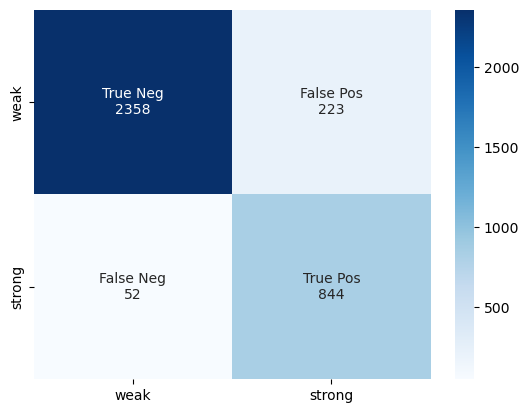

In [25]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2,2)

categories = ["weak", "strong"]
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues',xticklabels=categories, yticklabels=categories)
plt.savefig('cf_mat_cnn.png')

In [1]:
def parameters_to_gb(parameters_count):
    # Assuming each parameter is stored as float32 (4 bytes)
    bytes_required = parameters_count * 4
    # Convert bytes to gigabytes
    gb_required = bytes_required / (1024 ** 3)
    return gb_required

In [2]:
parameters_to_gb(882)

3.285706043243408e-06

In [3]:
def parameters_to_mb(parameters_count):
    # Assuming each parameter is stored as float32 (4 bytes)
    bytes_required = parameters_count * 4
    # Convert bytes to megabytes
    mb_required = bytes_required / (1024 ** 2)
    return mb_required

In [4]:
parameters_to_mb(882)

0.00336456298828125